In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import bootstrap
from copy import deepcopy
import json as json

In [2]:
proteins = ['A_LBP', 'FNfn10', 'M_FABP', 'A3D',  'Fyn_SH3', 'TNfn3'] 
proteins_plotnames = {'A_LBP':'A-LBP', 'FNfn10':'FNfn10', 'M_FABP':'M-FABP', 'A3D':'A3D', 'Fyn_SH3':'Fyn SH3', 'TNfn3':'TNfn3'}
colors = {'af2chi':"#009E74", 'HSP':"#56B4E9",'MD':"#D55C00",'af2chi_prior':"#F0E442"}

In [3]:
c36m_renumbering = {'TNfn3':801, 'Fyn_SH3':83, 'FNfn10':1415}
af2chi_renumbering = {'A_LBP':1}

In [4]:
blocksize = 100

In [5]:
def save_json(dictionary, outfile):
    with open(outfile, "w") as f:
        json.dump(dictionary, f)

In [6]:
def calc_methyl_S2_axis(traj, CC_atoms):
    methyl_S2_axis = {}

    for residue in traj.top.residues:
        residue = str(residue)
        #restype=residue[:3]
        #resnum=i+1 #int(residue[3:])

        resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
        resname = str(''.join(filter(lambda x: x.isalpha(), residue)))

        if 'HIS' in resname:
            resname = 'HIS'

        if resname not in CC_atoms:
            continue

        resatoms = traj.top.select(f'residue {resnum}{resname}')

        #print(resatoms, resname, resnum, residue)

        res_traj = traj.atom_slice(resatoms)

        res_S2_axis = []
        
        for i in range(len(CC_atoms[resname])):
            
            #Slice out relevant C atoms and get xyz coords
            C1 = CC_atoms[resname][i][0]
            C2 = CC_atoms[resname][i][1]
            atoms_CC = res_traj.top.select(f'name {C1} or name {C2}')
            atoms_CC_slice = res_traj.atom_slice(atoms_CC)
            CC_coords = atoms_CC_slice.xyz
            
            # Forward model from this paper: https://pubs.acs.org/doi/10.1021/ja0396955 (see start of SI methods)

            #Get xyz component of CC bond vector
            diff_CC = np.array([CC_coords[i][1]-CC_coords[i][0] for i in range(len(CC_coords))])
                        
            #Get CC bond vector length
            r_CC = np.array([np.linalg.norm(CC_coords[i][1]-CC_coords[i][0],axis=0) for i in range(len(CC_coords))])
            r_CC_avg = np.average(r_CC)
            
            xx_avg_sq = np.square(np.average(np.square(diff_CC[..., 0])))
            yy_avg_sq = np.square(np.average(np.square(diff_CC[..., 1])))
            zz_avg_sq = np.square(np.average(np.square(diff_CC[..., 2])))
            xy_avg_sq = np.square(np.average(diff_CC[..., 0]*diff_CC[..., 1]))
            xz_avg_sq = np.square(np.average(diff_CC[..., 0]*diff_CC[..., 2]))
            yz_avg_sq = np.square(np.average(diff_CC[..., 1]*diff_CC[..., 2]))

            S2_axis = (3/(2*r_CC_avg**4))*(xx_avg_sq + yy_avg_sq + zz_avg_sq + 2*xy_avg_sq + 2*xz_avg_sq + 2*yz_avg_sq) - 0.5
            
            res_S2_axis.append(S2_axis)
            
        methyl_S2_axis[residue] = res_S2_axis
    return methyl_S2_axis

def calc_methyl_S2_axis_blocks(traj, CC_atoms, blocksize):

    methyl_S2_axis = {}
    methyl_S2_axis_std = {}

    for residue in traj.top.residues:
        residue = str(residue)
        #restype=residue[:3]
        #resnum=i+1 #int(residue[3:])

        resnum = int(''.join(filter(lambda x: x.isdigit(), residue)))
        resname = str(''.join(filter(lambda x: x.isalpha(), residue)))

        if 'HIS' in resname:
            resname = 'HIS'

        if resname not in CC_atoms:
            continue

        resatoms = traj.top.select(f'residue {resnum}{resname}')

        #print(resatoms, resname, resnum, residue)

        res_traj = traj.atom_slice(resatoms)
        
        #Make a list of blocks of the trajectory with block size blocksize
        #res_traj_blocks = [res_traj[i:i+blocksize] for i in range(0, len(res_traj), blocksize)]
        res_traj_blocks = [res_traj[i:i+blocksize] for i in range(0, len(res_traj) - (len(res_traj) % blocksize), blocksize)]

        print(f'Nr res traj blocks: {len(res_traj_blocks)}')
        
        #Loop over the methyl types of this residue
        res_S2_axis = []
        res_S2_axis_std = []
        for i in range(len(CC_atoms[resname])):
            
            #Loop over blocks and calculate S2_axis for each block and average over all blocks
            res_S2_axis_vs_blocks = []
            for res_traj_block in res_traj_blocks:
                
                #Make sure block is of correct size
                assert len(res_traj_block) == blocksize

                #Slice out relevant C atoms and get xyz coords
                C1 = CC_atoms[resname][i][0]
                C2 = CC_atoms[resname][i][1]
                atoms_CC = res_traj_block.top.select(f'name {C1} or name {C2}')
                atoms_CC_slice = res_traj_block.atom_slice(atoms_CC)
                CC_coords = atoms_CC_slice.xyz
                
                # Forward model from this paper: https://pubs.acs.org/doi/10.1021/ja0396955 (see start of SI methods)

                #Get xyz component of CC bond vector
                diff_CC = np.array([CC_coords[i][1]-CC_coords[i][0] for i in range(len(CC_coords))])
                            
                #Get CC bond vector length
                r_CC = np.array([np.linalg.norm(CC_coords[i][1]-CC_coords[i][0],axis=0) for i in range(len(CC_coords))])
                r_CC_avg = np.average(r_CC)
                
                xx_avg_sq = np.square(np.average(np.square(diff_CC[..., 0])))
                yy_avg_sq = np.square(np.average(np.square(diff_CC[..., 1])))
                zz_avg_sq = np.square(np.average(np.square(diff_CC[..., 2])))
                xy_avg_sq = np.square(np.average(diff_CC[..., 0]*diff_CC[..., 1]))
                xz_avg_sq = np.square(np.average(diff_CC[..., 0]*diff_CC[..., 2]))
                yz_avg_sq = np.square(np.average(diff_CC[..., 1]*diff_CC[..., 2]))

                S2_axis = (3/(2*r_CC_avg**4))*(xx_avg_sq + yy_avg_sq + zz_avg_sq + 2*xy_avg_sq + 2*xz_avg_sq + 2*yz_avg_sq) - 0.5
                res_S2_axis_vs_blocks.append(S2_axis)
            
            #Average over blocks and append to list
            res_S2_axis.append(np.average(res_S2_axis_vs_blocks))
            res_S2_axis_std.append(np.std(res_S2_axis_vs_blocks))
                
        methyl_S2_axis[residue] = res_S2_axis
        methyl_S2_axis_std[residue] = res_S2_axis_std

    return methyl_S2_axis, methyl_S2_axis_std

In [7]:
with open(f'../data/S2_axis_expt/expt_dummymodel.json', 'r') as openfile:
    json_object = json.load(openfile)
dummy_avgs = json_object['dummy_avgs']
dummy_errs = json_object['dummy_errs']

<>:133: SyntaxWarning: invalid escape sequence '\c'
<>:134: SyntaxWarning: invalid escape sequence '\c'
<>:159: SyntaxWarning: invalid escape sequence '\c'
<>:133: SyntaxWarning: invalid escape sequence '\c'
<>:134: SyntaxWarning: invalid escape sequence '\c'
<>:159: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_206909/937283547.py:133: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_af2chi, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['af2chi'], markeredgecolor='black', ecolor='black', label=f'AF2$\chi$ {pearson_af2chi:.2f}±{pearson_err_af2chi:.2f}')
/tmp/ipykernel_206909/937283547.py:134: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_af2chi_prior, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['af2chi_prior'], markeredgecolor='black', ecolor='black', label=f'AF2$\chi$ prior {pearson_af2chi_prior:.2f}±{pearson_err_af2chi_prior:.2f}')
/tmp/ipykernel_206909/937283547.py:159: Sy

Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj blocks: 100
Nr res traj bloc

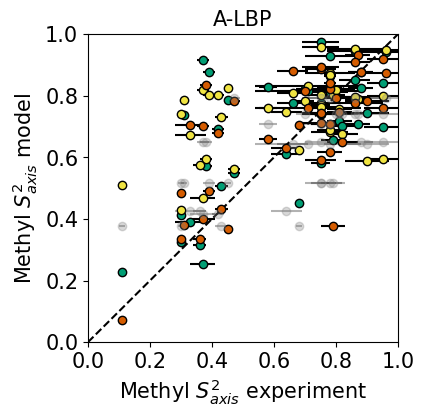

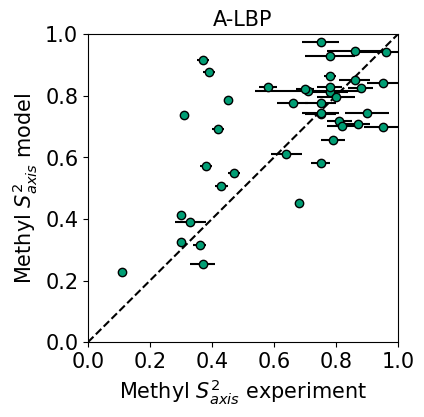

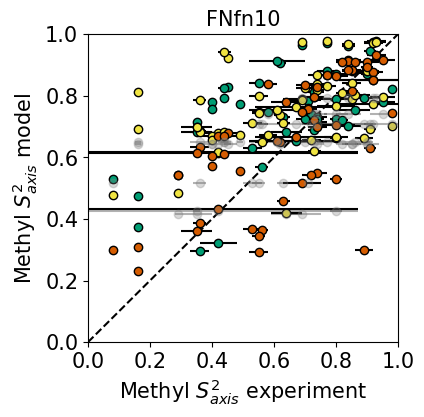

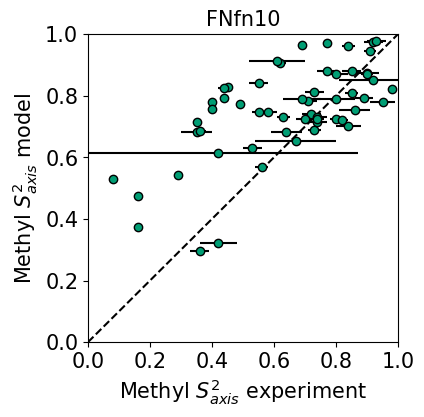

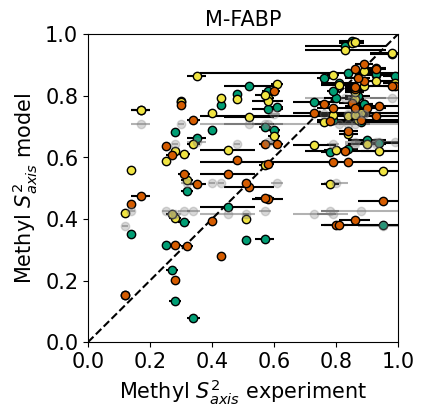

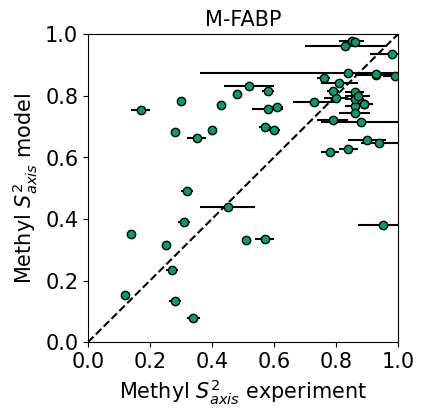

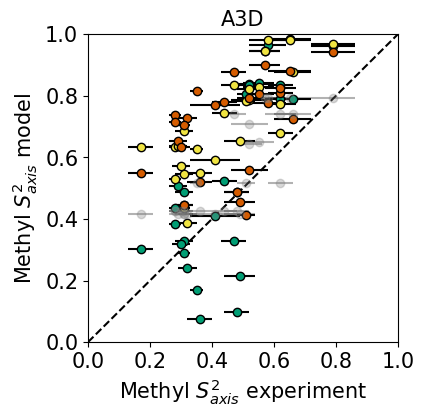

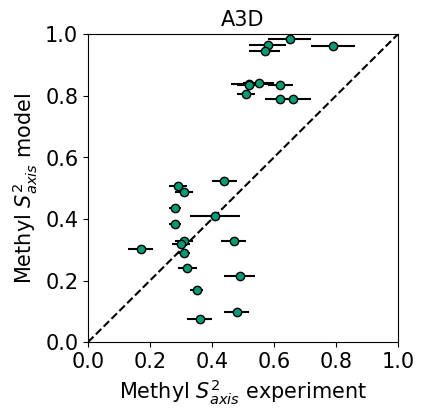

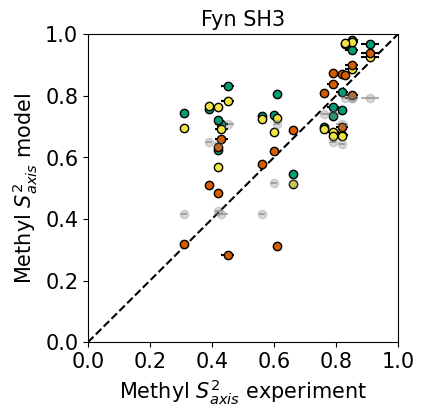

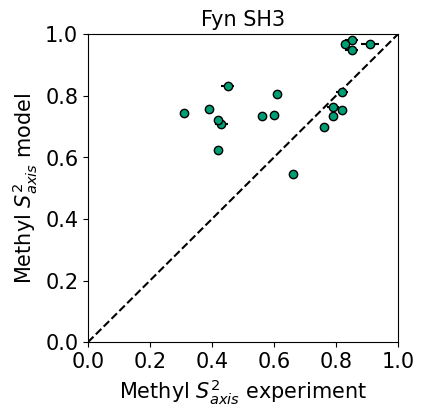

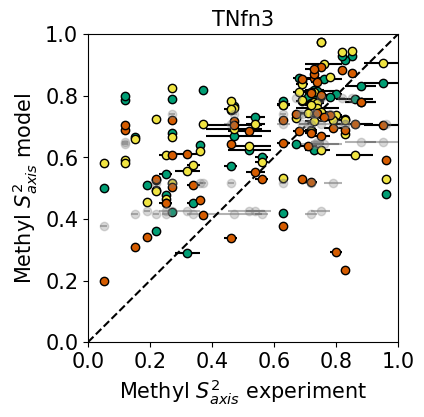

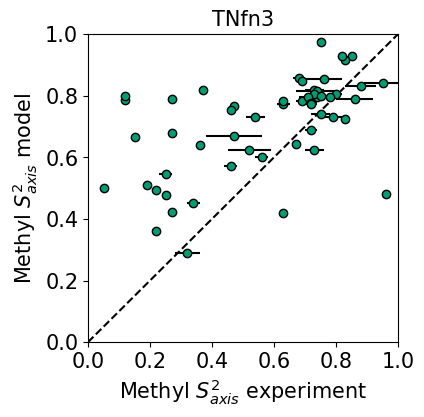

In [8]:
pearson_vs_model_vs_protein = {}
S2_axis_vs_model_vs_protein = {}
for protein in proteins:
    sidechain_ensemble_dir = f'../data/af2chi_data/af2chi_runs_S2proteins/{protein}/sidechain_ensemble_withH'
    sidechain_ensemble_prior_dir = f'../data/af2chi_data/af2chi_runs_S2proteins_priors/{protein}/sidechain_ensemble_withH'

    for frame_idx in range(100):
        #print(frame_idx)
        frame = md.load(f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_dir}/struc_{frame_idx}.pdb')
        frame.time = frame_idx
        if frame_idx==0:
            ensemble_af2chi=frame 
        else:
            ensemble_af2chi = ensemble_af2chi.join(frame)

    for frame_idx in range(100):
        #print(frame_idx)
        frame = md.load(f'{sidechain_ensemble_prior_dir}/struc_{frame_idx}.pdb', top=f'{sidechain_ensemble_prior_dir}/struc_{frame_idx}.pdb')
        frame.time = frame_idx
        if frame_idx==0:
            ensemble_af2chi_prior=frame 
        else:
            ensemble_af2chi_prior = ensemble_af2chi_prior.join(frame)

    #charmm36m traj
    charmm36m_traj = md.load(f'../data/MD_data/MD_charmm36m/{protein}.xtc', top=f'../data/MD_data/MD_charmm36m/{protein}.gro')

    #Iteratively get average coordinates and superpose to them
    ensemble_af2chi = ensemble_af2chi.superpose(ensemble_af2chi, frame=0, atom_indices=ensemble_af2chi.top.select('backbone'))
    ensemble_af2chi_prior = ensemble_af2chi_prior.superpose(ensemble_af2chi_prior, frame=0, atom_indices=ensemble_af2chi_prior.top.select('backbone'))
    charmm36m_traj = charmm36m_traj.superpose(charmm36m_traj, frame=0, atom_indices=charmm36m_traj.top.select('backbone'))

    for i in range(20):
        avg_frame_af2chi = deepcopy(ensemble_af2chi[0])
        avg_frame_af2chi.xyz = np.average(ensemble_af2chi.xyz, axis=0)

        avg_frame_af2chi_prior = deepcopy(ensemble_af2chi_prior[0])
        avg_frame_af2chi_prior.xyz = np.average(ensemble_af2chi_prior.xyz, axis=0)

        avg_frame_charmm36m = deepcopy(charmm36m_traj[0])
        avg_frame_charmm36m.xyz = np.average(charmm36m_traj.xyz, axis=0)

        ensemble_af2chi = ensemble_af2chi.superpose(avg_frame_af2chi, atom_indices=ensemble_af2chi.top.select('backbone'))
        ensemble_af2chi_prior = ensemble_af2chi_prior.superpose(avg_frame_af2chi_prior, atom_indices=ensemble_af2chi_prior.top.select('backbone'))
        charmm36m_traj = charmm36m_traj.superpose(avg_frame_charmm36m, atom_indices=charmm36m_traj.top.select('backbone'))

    #print(charmm36m_traj)

    with open(f'../data/S2_axis_expt/{protein}.json', 'r') as openfile:
        json_object = json.load(openfile)
    protein_S2_axis_expt = json_object['data']
    CC_atoms = json_object['CC_atoms']     

    af2chi_methyl_S2_axis = calc_methyl_S2_axis(ensemble_af2chi, CC_atoms)
    af2chi_prior_methyl_S2_axis = calc_methyl_S2_axis(ensemble_af2chi_prior, CC_atoms)
    charmm36m_methyl_S2_axis, charmm36m_methyl_S2_axis_std = calc_methyl_S2_axis_blocks(charmm36m_traj, CC_atoms, blocksize=blocksize)
    methyl_S2_axis_af2chi = []
    methyl_S2_axis_af2chi_prior = []
    methyl_S2_axis_charmm36m = []
    methyl_S2_axis_expt = []
    methyl_S2_axis_expterr = []
    methyl_S2_axis_dummy = []
    methyl_S2_axis_dummyerr = []

    print(af2chi_methyl_S2_axis)

    for res in protein_S2_axis_expt :
        print(res)
        for i,S2_axis in enumerate(protein_S2_axis_expt[res]):
            if protein in af2chi_renumbering.keys():
                af2chi_resnum = int(res[3:]) + af2chi_renumbering[protein]
                af2chi_res = res[:3] + str(af2chi_resnum)
                S2_axis_af2chi = af2chi_methyl_S2_axis[af2chi_res][i]
                S2_axis_af2chi_prior = af2chi_prior_methyl_S2_axis[af2chi_res][i]
            else:
                S2_axis_af2chi = af2chi_methyl_S2_axis[res][i]
                S2_axis_af2chi_prior = af2chi_prior_methyl_S2_axis[res][i]
            if protein in c36m_renumbering.keys():
                c36m_resnum = int(res[3:]) + c36m_renumbering[protein]
                c36m_res = res[:3] + str(c36m_resnum)
                S2_axis_charmm36m = charmm36m_methyl_S2_axis[c36m_res][i]
            else:
                S2_axis_charmm36m = charmm36m_methyl_S2_axis[res][i]
            S2_axis_expt = S2_axis[0]
            S2_axis_expterr = S2_axis[1]

            if S2_axis_expt != 'NaN':
                methyl_S2_axis_af2chi.append(S2_axis_af2chi)
                methyl_S2_axis_af2chi_prior.append(S2_axis_af2chi_prior)
                methyl_S2_axis_charmm36m.append(S2_axis_charmm36m)
                methyl_S2_axis_expt.append(S2_axis_expt)
                methyl_S2_axis_expterr.append(S2_axis_expterr)

                atoms = CC_atoms[res[:3]][i]
                methyl_S2_axis_dummy.append(dummy_avgs[f'{res[:3]}_{atoms[0]}_{atoms[1]}'])
                methyl_S2_axis_dummyerr.append(dummy_errs[f'{res[:3]}_{atoms[0]}_{atoms[1]}'])

    methyl_S2_axis_af2chi = np.array(methyl_S2_axis_af2chi)
    methyl_S2_axis_af2chi_prior = np.array(methyl_S2_axis_af2chi_prior)
    methyl_S2_axis_charmm36m = np.array(methyl_S2_axis_charmm36m)
    methyl_S2_axis_expt = np.array(methyl_S2_axis_expt)
    methyl_S2_axis_expterr = np.array(methyl_S2_axis_expterr)
    methyl_S2_axis_dummy = np.array(methyl_S2_axis_dummy)
    methyl_S2_axis_dummyerr = np.array(methyl_S2_axis_dummyerr)

    assert len(methyl_S2_axis_af2chi) == len(methyl_S2_axis_af2chi_prior) == len(methyl_S2_axis_expt) == len(methyl_S2_axis_expterr) == len(methyl_S2_axis_charmm36m)
    def pearsonoutput(x,y):
        return pearsonr(x,y)[0]

    bootstrap_result_af2chi = bootstrap((methyl_S2_axis_expt, methyl_S2_axis_af2chi), pearsonoutput, vectorized=False, paired=True)    
    pearson_err_af2chi = bootstrap_result_af2chi.standard_error

    bootstrap_result_af2chi_prior = bootstrap((methyl_S2_axis_expt, methyl_S2_axis_af2chi_prior), pearsonoutput, vectorized=False, paired=True)    
    pearson_err_af2chi_prior = bootstrap_result_af2chi_prior.standard_error

    bootstrap_result_charmm36m = bootstrap((methyl_S2_axis_expt, methyl_S2_axis_charmm36m), pearsonoutput, vectorized=False, paired=True)    
    pearson_err_charmm36m = bootstrap_result_charmm36m.standard_error

    bootstrap_result_dummy = bootstrap((methyl_S2_axis_expt, methyl_S2_axis_dummy), pearsonoutput, vectorized=False, paired=True)    
    pearson_err_dummy = bootstrap_result_dummy.standard_error

    pearson_af2chi = pearsonr(methyl_S2_axis_expt, methyl_S2_axis_af2chi)[0]
    pearson_af2chi_prior = pearsonr(methyl_S2_axis_expt, methyl_S2_axis_af2chi_prior)[0]
    pearson_charmm36m = pearsonr(methyl_S2_axis_expt, methyl_S2_axis_charmm36m)[0]
    pearson_dummy = pearsonr(methyl_S2_axis_expt, methyl_S2_axis_dummy)[0]

    fig = plt.figure(figsize=(4,4))

    plt.title(proteins_plotnames[protein], fontsize=15)

    plt.plot([0,1], [0,1], '--', c='k')

    plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_af2chi, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['af2chi'], markeredgecolor='black', ecolor='black', label=f'AF2$\chi$ {pearson_af2chi:.2f}±{pearson_err_af2chi:.2f}')
    plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_af2chi_prior, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['af2chi_prior'], markeredgecolor='black', ecolor='black', label=f'AF2$\chi$ prior {pearson_af2chi_prior:.2f}±{pearson_err_af2chi_prior:.2f}')
    plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_charmm36m, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['MD'], markeredgecolor='black', ecolor='black', label=f'CHARMM36m {pearson_charmm36m:.2f}±{pearson_err_charmm36m:.2f}')
    plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_dummy, xerr=methyl_S2_axis_expterr, fmt='o', c='gray', alpha=0.3, ecolor='black', label=f'Null model {pearson_dummy:.2f}±{pearson_err_dummy:.2f}')

    #plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)

    plt.ylabel('Methyl $S^{2}_{axis}$ model', fontsize=15)
    plt.xlabel('Methyl $S^{2}_{axis}$ experiment', fontsize=15)

    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xticks(np.arange(0,1.1,0.2))
    plt.yticks(np.arange(0,1.1,0.2))

    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)

    plt.savefig(f'../figures/{protein}_S2_allmodels.pdf', bbox_inches='tight')

    fig = plt.figure(figsize=(4,4))

    plt.title(proteins_plotnames[protein], fontsize=15)

    plt.plot([0,1], [0,1], '--', c='k')

    plt.errorbar(methyl_S2_axis_expt, methyl_S2_axis_af2chi, xerr=methyl_S2_axis_expterr, fmt='o', c=colors['af2chi'], markeredgecolor='black', ecolor='black', label=f'AF2$\chi$ {pearson_af2chi:.2f}±{pearson_err_af2chi:.2f}')

    #plt.legend(fontsize=15, bbox_to_anchor=(1,1.3), ncol=3)

    plt.ylabel('Methyl $S^{2}_{axis}$ model', fontsize=15)
    plt.xlabel('Methyl $S^{2}_{axis}$ experiment', fontsize=15)

    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.xticks(np.arange(0,1.1,0.2))
    plt.yticks(np.arange(0,1.1,0.2))

    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)

    plt.savefig(f'../figures/{protein}_S2_af2chionly.pdf', bbox_inches='tight')

    print(pearson_af2chi, pearson_err_af2chi)
    print(pearson_af2chi_prior, pearson_err_af2chi_prior)
    print(pearson_charmm36m, pearson_err_charmm36m)
    print(pearson_dummy, pearson_err_dummy)

    S2_axis_vs_model = {}
    S2_axis_vs_model['af2chi'] = list(methyl_S2_axis_af2chi)
    S2_axis_vs_model['af2chi_prior'] = list(methyl_S2_axis_af2chi_prior)
    S2_axis_vs_model['charmm36m'] = list(methyl_S2_axis_charmm36m)
    S2_axis_vs_model['expt'] = list(methyl_S2_axis_expt)
    S2_axis_vs_model['expt_err'] = list(methyl_S2_axis_expterr)
    S2_axis_vs_model['dummy'] = list(methyl_S2_axis_dummy)
    S2_axis_vs_model['dummy_err'] = list(methyl_S2_axis_dummyerr)
    
    S2_axis_vs_model_vs_protein[protein] = S2_axis_vs_model

    pearson_vs_model = {}
    pearson_vs_model['af2chi'] = pearson_af2chi
    pearson_vs_model['af2chi_err'] = pearson_err_af2chi
    pearson_vs_model['af2chi_prior'] = pearson_af2chi_prior
    pearson_vs_model['af2chi_prior_err'] = pearson_err_af2chi_prior
    pearson_vs_model['charmm36m'] = pearson_charmm36m
    pearson_vs_model['charmm36m_err'] = pearson_err_charmm36m
    pearson_vs_model['dummy'] = pearson_dummy   
    pearson_vs_model['dummy_err'] = pearson_err_dummy

    pearson_vs_model_vs_protein[protein] = pearson_vs_model

save_json(S2_axis_vs_model_vs_protein, '../data/S2_axis_expt/S2_models.json')
save_json(pearson_vs_model_vs_protein, '../data/S2_axis_expt/pearson_models_expt.json')

# Plot correlations barplot

In [9]:
def load_json(file):
    with open(file, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

In [10]:
proteins_plotorder = ['A_LBP', 'M_FABP', 'FNfn10', 'TNfn3', 'A3D', 'Fyn_SH3']

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_206909/1482403968.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.bar(i-0.3, pearson_vs_model_vs_protein[protein]['af2chi'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_err'], edgecolor='k', color=colors['af2chi'], width=0.15, label='AF2$\chi$')
/tmp/ipykernel_206909/1482403968.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.bar(i-0.1, pearson_vs_model_vs_protein[protein]['af2chi_prior'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_prior_err'], edgecolor='k', color=colors['af2chi_prior'], width=0.15, label='AF2$\chi$ prior')
/tmp/ipykernel_206909/1482403968.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$r_\mathrm{Pearson}$', fon

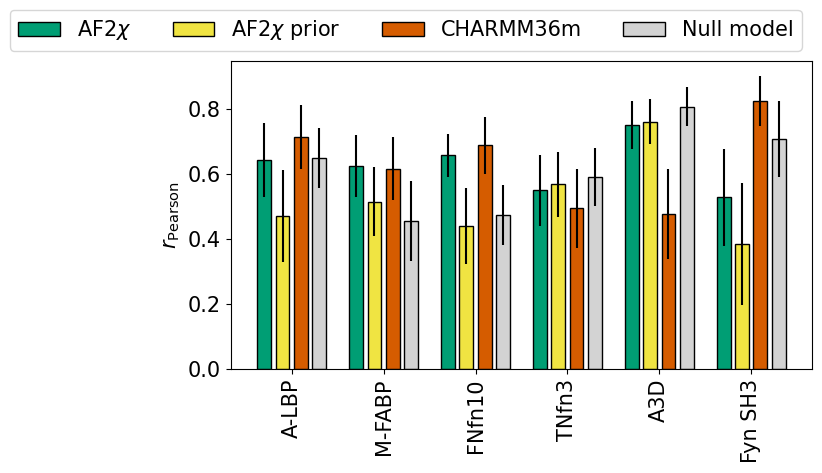

In [11]:
pearson_vs_model_vs_protein = load_json('../data/S2_axis_expt/pearson_models_expt.json')

fig = plt.figure(figsize=(7.5,4))

for i,protein in enumerate(proteins_plotorder):

    if i==0:
        plt.bar(i-0.3, pearson_vs_model_vs_protein[protein]['af2chi'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_err'], edgecolor='k', color=colors['af2chi'], width=0.15, label='AF2$\chi$')
        plt.bar(i-0.1, pearson_vs_model_vs_protein[protein]['af2chi_prior'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_prior_err'], edgecolor='k', color=colors['af2chi_prior'], width=0.15, label='AF2$\chi$ prior')
        plt.bar(i+0.1, pearson_vs_model_vs_protein[protein]['charmm36m'], yerr=pearson_vs_model_vs_protein[protein]['charmm36m_err'], edgecolor='k', color=colors['MD'], width=0.15, label='CHARMM36m')
        plt.bar(i+0.3, pearson_vs_model_vs_protein[protein]['dummy'], yerr=pearson_vs_model_vs_protein[protein]['dummy_err'], edgecolor='k', color='lightgray', width=0.15, label='Null model')
    else:
        plt.bar(i-0.3, pearson_vs_model_vs_protein[protein]['af2chi'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_err'], edgecolor='k', color=colors['af2chi'], width=0.15)
        plt.bar(i-0.1, pearson_vs_model_vs_protein[protein]['af2chi_prior'], yerr=pearson_vs_model_vs_protein[protein]['af2chi_prior_err'], edgecolor='k', color=colors['af2chi_prior'], width=0.15)
        plt.bar(i+0.1, pearson_vs_model_vs_protein[protein]['charmm36m'], yerr=pearson_vs_model_vs_protein[protein]['charmm36m_err'], edgecolor='k', color=colors['MD'], width=0.15)
        plt.bar(i+0.3, pearson_vs_model_vs_protein[protein]['dummy'], yerr=pearson_vs_model_vs_protein[protein]['dummy_err'], edgecolor='k', color='lightgray', width=0.15)

plt.ylabel('$r_\mathrm{Pearson}$', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(ticks=np.arange(len(proteins_plotorder)), labels=[proteins_plotnames[protein] for protein in proteins_plotorder], rotation=90, fontsize=15)

plt.legend(fontsize=15, bbox_to_anchor=(1,1.2), ncol=4)

plt.savefig(f'../figures/S2_pearson_allproteins.png', bbox_inches='tight')
plt.savefig(f'../figures/S2_pearson_allproteins.pdf', bbox_inches='tight')
